# Processing of TfL Cycle Data
Raphael Canty k20074927

Data downloaded from <https://cycling.data.tfl.gov.uk> and <https://api.tfl.gov.uk>

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import json
import urllib3

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


## Processing Stop Points

Organising API returned list of stop points

In [100]:
stations = pd.read_json("../cycle_data/BikePoint.json")
stations.drop(['$type', 'url', 'placeType', 
                   'additionalProperties', 'children', 'childrenUrls'], axis=1, inplace=True)
stations

,id,commonName,lat,lon
0,BikePoints_1,"River Street , Clerkenwell",51.529163,-0.109970
1,BikePoints_2,"Phillimore Gardens, Kensington",51.499606,-0.197574
2,BikePoints_3,"Christopher Street, Liverpool Street",51.521283,-0.084605
3,BikePoints_4,"St. Chad's Street, King's Cross",51.530059,-0.120973
4,BikePoints_5,"Sedding Street, Sloane Square",51.493130,-0.156876
...,...,...,...,...
780,BikePoints_270,"Kennington Lane Rail Bridge, Vauxhall",51.486343,-0.122492
781,BikePoints_272,"Baylis Road, Waterloo",51.501444,-0.110699
782,BikePoints_290,"St Mary's Hospital, Paddington",51.518268,-0.171103
783,BikePoints_300,"Serpentine Car Park, Hyde Park",51.505014,-0.173060


In [102]:
stations['id'] = stations.id.apply(lambda x: x[11:]).astype(int)
stations.rename({'commonName': 'StationName', 'lat': 'latitude', 'lon': 'longitude'}, axis=1, inplace=True)
stations.set_index('id', inplace=True)
stations

,StationName,latitude,longitude
id,,,
1,"River Street , Clerkenwell",51.529163,-0.109970
2,"Phillimore Gardens, Kensington",51.499606,-0.197574
3,"Christopher Street, Liverpool Street",51.521283,-0.084605
4,"St. Chad's Street, King's Cross",51.530059,-0.120973
5,"Sedding Street, Sloane Square",51.493130,-0.156876
...,...,...,...
270,"Kennington Lane Rail Bridge, Vauxhall",51.486343,-0.122492
272,"Baylis Road, Waterloo",51.501444,-0.110699
290,"St Mary's Hospital, Paddington",51.518268,-0.171103


## Creating city metric
True if stop is within a radius of London's centroid or within the City of London

In [103]:
# Converting to GeoPandas for geographic manipulation
stations = gpd.GeoDataFrame(api_stations, geometry=[Point(xy) for xy in
                                                    zip(api_stations.latitude, api_stations.longitude)])

In [104]:
LONDON = (51.507222, -0.1275)
london_center = Point(LONDON)

In [59]:
# Gets distance of each station from London centroid using graphhopper API
from api_key import API_KEY
import time

distances = {}
for s in stations.iloc:
    url = 'https://graphhopper.com/api/1/route'
    url += f'?point={LONDON[0]},{LONDON[1]}&point={s.latitude},{s.longitude}&vehicle=bike&instructions=false&calc_points=false&key={API_KEY}'
    r = http.request('GET', url)
    data = json.loads(r.data)
    distances[s.name] = data['paths'][0]['distance']
    time.sleep(0.5)
print('done')

done


In [62]:
# Converting metres to kilometres
stations['dist'] = pd.Series(distances) / 1000

In [107]:
# Loading borough information
boroughs = gpd.read_file('../statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')
boroughs.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((516401.600 160201.800, 516407.300 16..."
1,Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((535009.200 159504.700, 535005.500 15..."
2,Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((540373.600 157530.400, 540361.200 15..."
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((521975.800 178100.000, 521967.700 17..."
4,Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((510253.500 182881.600, 510249.900 18..."


In [193]:
city = boroughs.loc[32:32]
city.geometry = city.geometry.buffer(400).to_crs('EPSG:4326')
city

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
32,City of London,E09000001,314.942,24.546,T,None,None,"POLYGON ((-0.11734 51.51070, -0.11738 51.51074..."


In [194]:
stations.geometry = [Point(xy) for xy in zip(api_stations.longitude, api_stations.latitude)]
stations.geometry.set_crs('EPSG:4326')
stations

,StationName,latitude,longitude,geometry,dist,city,colour,col
id,,,,,,,,
1,"River Street , Clerkenwell",51.529163,-0.109970,POINT (-0.10997 51.52916),3.379066,False,#444444,False
2,"Phillimore Gardens, Kensington",51.499606,-0.197574,POINT (-0.19757 51.49961),5.376175,False,#777777,False
3,"Christopher Street, Liverpool Street",51.521283,-0.084605,POINT (-0.08460 51.52128),3.977612,True,#555555,True
4,"St. Chad's Street, King's Cross",51.530059,-0.120973,POINT (-0.12097 51.53006),3.403407,False,#444444,False
5,"Sedding Street, Sloane Square",51.493130,-0.156876,POINT (-0.15688 51.49313),3.130922,True,#444444,False
...,...,...,...,...,...,...,...,...
270,"Kennington Lane Rail Bridge, Vauxhall",51.486343,-0.122492,POINT (-0.12249 51.48634),3.225420,True,#444444,False
272,"Baylis Road, Waterloo",51.501444,-0.110699,POINT (-0.11070 51.50144),2.017063,True,#333333,False
290,"St Mary's Hospital, Paddington",51.518268,-0.171103,POINT (-0.17110 51.51827),4.475438,False,#666666,False


In [195]:
city

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
32,City of London,E09000001,314.942,24.546,T,None,None,"POLYGON ((-0.11734 51.51070, -0.11738 51.51074..."


In [254]:
# Defining a city stop as one which is less than 3.25km from London's centroid
stations['city'] = (stations['dist'] < 3.25) | (stations.geometry.within(city.loc[32].geometry))
stations

,StationName,latitude,longitude,geometry,dist,city
id,,,,,,
1,"River Street , Clerkenwell",51.529163,-0.109970,POINT (-0.10997 51.52916),3.379066,False
2,"Phillimore Gardens, Kensington",51.499606,-0.197574,POINT (-0.19757 51.49961),5.376175,False
3,"Christopher Street, Liverpool Street",51.521283,-0.084605,POINT (-0.08460 51.52128),3.977612,True
4,"St. Chad's Street, King's Cross",51.530059,-0.120973,POINT (-0.12097 51.53006),3.403407,False
5,"Sedding Street, Sloane Square",51.493130,-0.156876,POINT (-0.15688 51.49313),3.130922,True
...,...,...,...,...,...,...
270,"Kennington Lane Rail Bridge, Vauxhall",51.486343,-0.122492,POINT (-0.12249 51.48634),3.225420,True
272,"Baylis Road, Waterloo",51.501444,-0.110699,POINT (-0.11070 51.50144),2.017063,True
290,"St Mary's Hospital, Paddington",51.518268,-0.171103,POINT (-0.17110 51.51827),4.475438,False


In [204]:
stations.drop('geometry', axis=1).to_csv('../cycle_data/bike_stations.csv')

In [197]:
# Visualising with Folium
import folium

m = folium.Map(location=LONDON, zoom_start=10)
stations.apply(lambda row: folium.CircleMarker(location=[row["latitude"], row["longitude"]], 
                                               radius=5, popup=row['StationName'],
                                               color=('#ff0000' if row.city else '#0000ff')).add_to(m), axis=1)
folium.GeoJson(data=city).add_to(m)
m

In [108]:
# Applying colour in a hex scale to visualise distance of each station
#def apply_colour(v):
#    return '#'+str(hex(round((v.dist/stations.dist.max())*15)))[2]*6
#stations['colour'] = stations.apply(apply_colour, axis=1)

In [2]:
stations = pd.read_csv('../cycle_data/bike_stations.csv').set_index('id')

## Importing trip data

In [3]:
def bucket_duration(dur):
    """Buckets duration into a string category"""
    if dur <= 5:
        return '_5'
    elif dur <= 10:
        return '6_10'
    elif dur <= 15:
        return '11_15'
    elif dur <= 20:
        return '16_20'
    elif dur <= 25:
        return '21_25'
    elif dur <= 30:
        return '26_30'
    elif dur <= 40:
        return '31_40'
    elif dur <= 50:
        return '41_50'
    elif dur <= 60:
        return '51_60'
    elif dur <= 120:
        return '61_120'
    else:
        return '120_'

In [4]:
files = !ls ../cycle_data
files.remove('BikePoint.json')
files.remove('bike_stations.csv')
files

['143JourneyDataExtract02Jan2019-08Jan2019.csv',
 '144JourneyDataExtract09Jan2019-15Jan2019.csv',
 '145JourneyDataExtract16Jan2019-22Jan2019.csv',
 '146JourneyDataExtract23Jan2019-29Jan2019.csv',
 '147JourneyDataExtract30Jan2019-05Feb2019.csv',
 '148JourneyDataExtract06Feb2019-12Feb2019.csv',
 '149JourneyDataExtract13Feb2019-19Feb2019.csv',
 '150JourneyDataExtract20Feb2019-26Feb2019.csv',
 '151JourneyDataExtract27Feb2019-05Mar2019.csv',
 '152JourneyDataExtract06Mar2019-12Mar2019.csv',
 '153JourneyDataExtract13Mar2019-19Mar2019.csv',
 '154JourneyDataExtract20Mar2019-26Mar2019.csv',
 '155JourneyDataExtract27Mar2019-02Apr2019.csv',
 '156JourneyDataExtract03Apr2019-09Apr2019.csv',
 '157JourneyDataExtract10Apr2019-16Apr2019.csv',
 '158JourneyDataExtract17Apr2019-23Apr2019.csv',
 '159JourneyDataExtract24Apr2019-30Apr2019.csv',
 '160JourneyDataExtract01May2019-07May2019.csv',
 '161JourneyDataExtract08May2019-14May2019.csv',
 '162JourneyDataExtract15May2019-21May2019.csv',
 '163JourneyDataExtr

In [40]:
data = pd.DataFrame(columns=['duration', 'city', 'suburb', 'city_suburb', 'total', 'mean_duration',
                             'median_duration', 'max_duration', '_5', '6_10', '11_15', '16_20',
                             '21_25', '26_30', '31_40', '41_50', '51_60', '61_120', '120_'])
for file in files:
    print(file, end=' ')
    curr_data = pd.DataFrame(columns=['duration', 'mean_duration', 'median_duration', 'max_duration', 'city', 'suburb', 'city_suburb'])
    curr_bike = pd.read_csv("../cycle_data/" + file)
    # Converts dates to workable format
    curr_bike['Start Date'] = pd.to_datetime(curr_bike['Start Date'], format='%d/%m/%Y %H:%M').dt.floor('d')
    # Converts duration seconds to minutes
    curr_bike['Duration'] = round(curr_bike.Duration / 60)
    # Merges city/non-city classification
    curr_bike = curr_bike.merge(stations.city, left_on='StartStation Id', right_on='id', how='left')
    curr_bike.rename({"city": "start_city"}, axis=1, inplace=True)
    curr_bike = curr_bike.merge(stations.city, left_on='EndStation Id', right_on='id', how='left')
    curr_bike.rename({"city": "end_city"}, axis=1, inplace=True)
    # Fetches duration statistics
    curr_bgb = curr_bike.groupby(by='Start Date')
    curr_data['duration'] = curr_bgb.Duration.sum()
    curr_data['mean_duration'] = curr_bgb.Duration.mean()
    curr_data['median_duration'] = curr_bgb.Duration.median()
    curr_data['max_duration'] = curr_bgb.Duration.max()
    curr_data['total'] = curr_bgb.Duration.count()
    # Removes missing stations, keeping count of total number of trips
    print(len(curr_bike), end=' ')
    curr_bike.dropna(axis=0, how='any', inplace=True)
    print(len(curr_bike))
    # Adds boolean fields classifying ride types
    curr_bike.start_city = curr_bike.start_city.astype(bool)
    curr_bike.end_city = curr_bike.end_city.astype(bool)
    curr_bike['city'] = curr_bike.start_city & curr_bike.end_city
    curr_bike['suburb'] = ~curr_bike.start_city & ~curr_bike.end_city
    curr_bike['city_suburb'] = np.logical_xor(curr_bike.start_city, curr_bike.end_city)
    curr_data[['city', 'suburb', 'city_suburb']] = curr_bike.groupby('Start Date')[['city', 'suburb', 'city_suburb']].sum()
    # Adds duration buckets to data
    curr_bike['duration_bucket'] = curr_bike.Duration.apply(bucket_duration)
    data = data.append(pd.concat((curr_data,
                                  curr_bike.groupby(['Start Date',
                                                     'duration_bucket'])['Duration'].count().unstack()),
                                 axis=1))

143JourneyDataExtract02Jan2019-08Jan2019.csv 142413 137010
144JourneyDataExtract09Jan2019-15Jan2019.csv 168000 161209
145JourneyDataExtract16Jan2019-22Jan2019.csv 157831 151494
146JourneyDataExtract23Jan2019-29Jan2019.csv 148916 142935
147JourneyDataExtract30Jan2019-05Feb2019.csv 133169 127889
148JourneyDataExtract06Feb2019-12Feb2019.csv 153271 147121
149JourneyDataExtract13Feb2019-19Feb2019.csv 183115 176394
150JourneyDataExtract20Feb2019-26Feb2019.csv 208701 201146
151JourneyDataExtract27Feb2019-05Mar2019.csv 177766 170690
152JourneyDataExtract06Mar2019-12Mar2019.csv 153984 147856
153JourneyDataExtract13Mar2019-19Mar2019.csv 159525 153060
154JourneyDataExtract20Mar2019-26Mar2019.csv 204420 195988
155JourneyDataExtract27Mar2019-02Apr2019.csv 206595 198668
156JourneyDataExtract03Apr2019-09Apr2019.csv 167846 161483
157JourneyDataExtract10Apr2019-16Apr2019.csv 191491 184345
158JourneyDataExtract17Apr2019-23Apr2019.csv 252721 243042
159JourneyDataExtract24Apr2019-30Apr2019.csv 212572 2037

In [41]:
data.to_csv('../datasets/TfL_cycle.csv')
data

,duration,city,suburb,city_suburb,total,mean_duration,median_duration,max_duration,_5,6_10,11_15,16_20,21_25,26_30,31_40,41_50,51_60,61_120,120_
2019-01-02,358875.0,6157,6051,6592,19552,18.354900,13.0,6578.0,2708,4850,4086,2828,1855,948,609,264,171,356,125
2019-01-03,361027.0,6681,6297,7548,21346,16.913098,12.0,5551.0,2992,5545,4626,3209,2018,941,489,216,147,248,95
2019-01-04,344051.0,6281,6516,7134,20666,16.648166,12.0,6088.0,3142,5514,4425,3020,1802,853,466,210,126,274,99
2019-01-05,253234.0,2866,6597,3803,13770,18.390269,12.0,4244.0,2272,3320,2631,1835,1212,738,457,248,173,234,146
2019-01-06,294908.0,2735,7160,3792,14131,20.869578,13.0,3390.0,2083,3121,2685,1929,1454,764,592,292,183,427,157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-30,547650.0,6909,11809,8676,27498,19.915994,13.0,5633.0,3476,6871,5899,4368,2820,1507,991,436,269,502,255
2021-07-31,849436.0,8154,15895,10781,34932,24.316844,16.0,4482.0,3332,6698,6694,5802,4227,2620,2102,1108,635,1136,476
2021-08-01,868010.0,8645,14586,10622,33986,25.540222,17.0,3656.0,2958,6092,6247,5525,4403,2679,2155,1104,682,1443,565
2021-08-02,682715.0,8554,14129,11103,33914,20.130772,14.0,2857.0,3670,7680,7029,5566,3841,2086,1531,710,447,912,314


In [331]:
lockdown_data = data[['city', 'suburb', 'city_suburb', 'count']]
lockdown_data['unclassified'] = lockdown_data['count'] - lockdown_data[['city', 'suburb', 'city_suburb']].sum(axis=1)
lockdown_data.iloc[364:942].to_csv('../datasets/cycle_lockdown.csv')

<ipython-input-331-330128237989>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lockdown_data['unclassified'] = lockdown_data['count'] - lockdown_data[['city', 'suburb', 'city_suburb']].sum(axis=1)


## Mobility Index computation

In [42]:
data['day'] = data.index.weekday
data['we'] = data.index.weekday >= 5
data

,duration,city,suburb,city_suburb,total,mean_duration,median_duration,max_duration,_5,6_10,...,16_20,21_25,26_30,31_40,41_50,51_60,61_120,120_,day,we
2019-01-02,358875.0,6157,6051,6592,19552,18.354900,13.0,6578.0,2708,4850,...,2828,1855,948,609,264,171,356,125,2,False
2019-01-03,361027.0,6681,6297,7548,21346,16.913098,12.0,5551.0,2992,5545,...,3209,2018,941,489,216,147,248,95,3,False
2019-01-04,344051.0,6281,6516,7134,20666,16.648166,12.0,6088.0,3142,5514,...,3020,1802,853,466,210,126,274,99,4,False
2019-01-05,253234.0,2866,6597,3803,13770,18.390269,12.0,4244.0,2272,3320,...,1835,1212,738,457,248,173,234,146,5,True
2019-01-06,294908.0,2735,7160,3792,14131,20.869578,13.0,3390.0,2083,3121,...,1929,1454,764,592,292,183,427,157,6,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-30,547650.0,6909,11809,8676,27498,19.915994,13.0,5633.0,3476,6871,...,4368,2820,1507,991,436,269,502,255,4,False
2021-07-31,849436.0,8154,15895,10781,34932,24.316844,16.0,4482.0,3332,6698,...,5802,4227,2620,2102,1108,635,1136,476,5,True
2021-08-01,868010.0,8645,14586,10622,33986,25.540222,17.0,3656.0,2958,6092,...,5525,4403,2679,2155,1104,682,1443,565,6,True
2021-08-02,682715.0,8554,14129,11103,33914,20.130772,14.0,2857.0,3670,7680,...,5566,3841,2086,1531,710,447,912,314,0,False


In [79]:
# First year
data_2019 = data.iloc[:424]['total']
data_2020 = data.iloc[364:788]['total']
len(data_2019), len(data_2020)

(424, 424)

In [80]:
data_2019.index = data_2019.index.shift(periods=364, freq='D')
mi_2020 = data_2020.divide(data_2019) * 100

In [81]:
# Second year
data_2021 = data.iloc[788:942]['total']
data_2019_2 = data.iloc[60:214]['total']
len(data_2019_2), len(data_2021)

(154, 154)

In [82]:
data_2019_2.index = data_2019_2.index.shift(periods=728, freq='D')
mi_2021 = data_2021.divide(data_2019_2) * 100

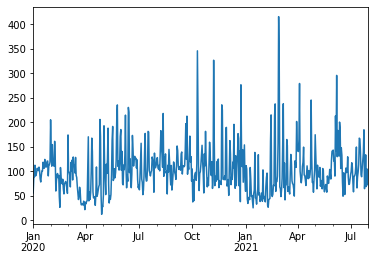

In [84]:
mi = pd.concat((mi_2020, mi_2021))
mi.plot()
mi.to_csv('../datasets/TfL_cycle_index.csv')

In [44]:
# Testing out an alternative calculation
data['total'] = data['total'].astype(int)
baseline = data.iloc[366:401][['total','day']].groupby('day').median().to_dict()['total']  # :364 for 2019
mi_v2 = pd.DataFrame(index=mi.index, columns=['ind'])
mi_v2['ind'] = mi_v2.apply(lambda x: (data.loc[x.name]['total'] / baseline_2[data.loc[x.name].day]), axis=1)*100

## Visualisation

<AxesSubplot:>

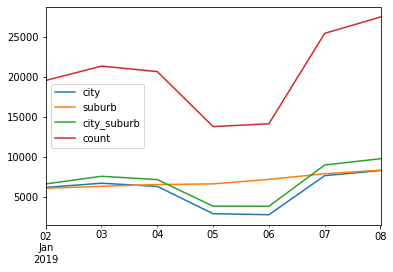

In [311]:
data.loc[:,'city':'count'].plot()